# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

• Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

• Контролировать добросовестность кассиров при продаже алкоголя. Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Посмотрим на размер выборки:

In [3]:
labels.shape

(7591, 2)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Размер выборки выведен. Выборка относительно небольшая, но мы еще можем нарастить ее, применяя аугментации


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Построим график распределения возраста в выборке:

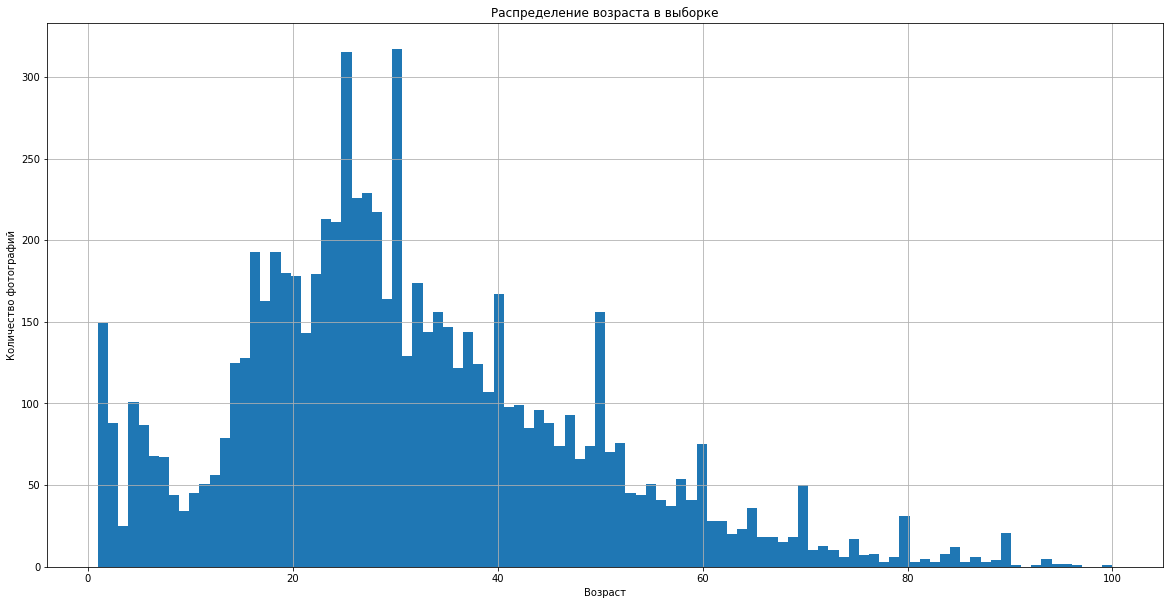

In [15]:
labels.hist(bins=100, figsize=(20, 10))
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.grid(True)
plt.show()

Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет:

Возраст человека на фото: 41


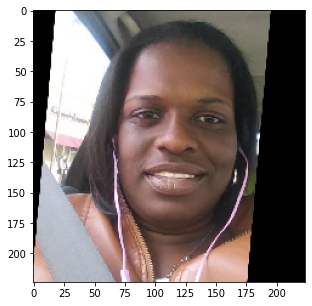

Возраст человека на фото: 46


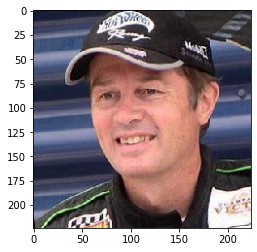

Возраст человека на фото: 85


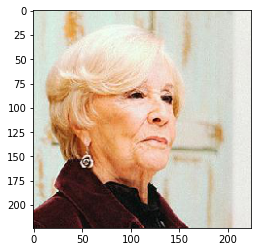

Возраст человека на фото: 14


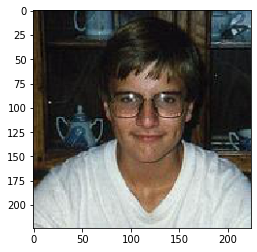

Возраст человека на фото: 40


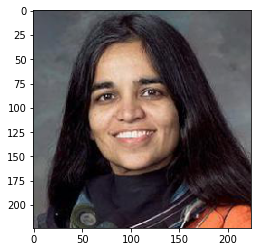

Возраст человека на фото: 14


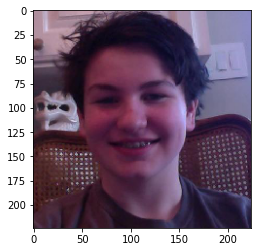

Возраст человека на фото: 53


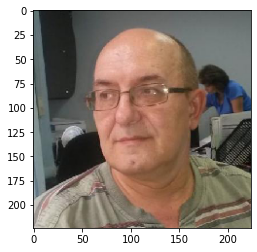

Возраст человека на фото: 4


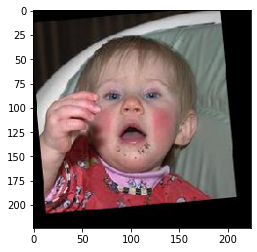

Возраст человека на фото: 32


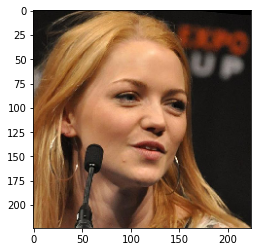

Возраст человека на фото: 14


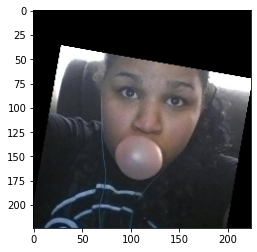

Возраст человека на фото: 23


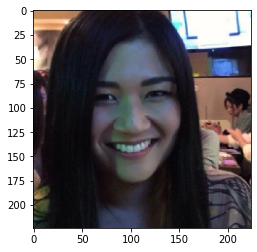

Возраст человека на фото: 37


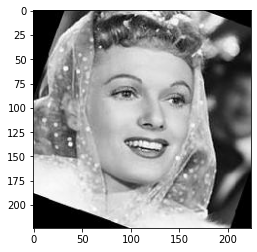

Возраст человека на фото: 62


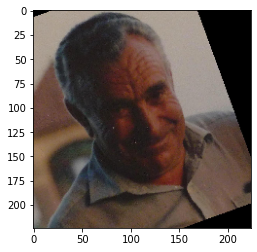

Возраст человека на фото: 21


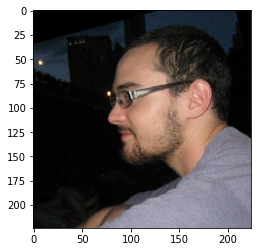

Возраст человека на фото: 58


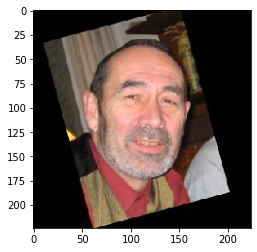

In [6]:
features, target = next(train_gen_flow)

plt.figure(figsize=(5, 5))

for i in range(1,16):
    plt.imshow(features[i])
    print(f'Возраст человека на фото: {target[i]}')
    plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Примеры фотографий выведены. Отлично, что указан возраст у фотографий!

**Вывод:**

1. В датасет расположен набор данных из 7591 пары объектов для возрастной категории от 1 до 100 лет, что скорее всего является небольшой выборкой для оценки возраста;

2. Распределение на графике возраста напоминает естественную возрастную структуру человеческой популяции, большинство изображенных на фото в диапазоне от 20 до 41 года;

3. Помимо того, что в датасете неравномерно представлены возрастные группы, среди которых у старших меньше всего, а также наличие нечеткого изображения лиц (закрывающие посторонние предметы например),что может негативно отразиться в обучении нейросети.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >

```
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Модель определена правильно! Отлично, что применен горизонтальный флип на тренировочной части

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 77s - loss: 196.4183 - mae: 10.1655 - val_loss: 592.9332 - val_mae: 19.0454
Epoch 2/10
356/356 - 60s - loss: 83.4999 - mae: 6.9482 - val_loss: 167.2919 - val_mae: 9.7279
Epoch 3/10
356/356 - 48s - loss: 56.3063 - mae: 5.6967 - val_loss: 72.2775 - val_mae: 6.3781
Epoch 4/10
356/356 - 49s - loss: 42.9371 - mae: 4.9768 - val_loss: 80.8611 - val_mae: 6.7140
Epoch 5/10
356/356 - 56s - loss: 32.2789 - mae: 4.3617 - val_loss: 69.5647 - val_mae: 6.3543
Epoch 6/10
356/356 - 52s - loss: 26.0127 - mae: 3.8619 - val_loss: 76.0482 - val_mae: 6.6263
Epoch 7/10
356/356 - 44s - loss: 20.7335 - mae: 3.4688 - val_loss: 83.4935 - val_mae: 6.7851
Epoch 8/10
356/356 - 55s - loss: 16.6822 - mae: 3.1045 - val_loss: 67.7693 - val_mae: 6.1999
Epoch 9/10
356/356 - 56s - loss: 13.8799 - mae: 2.8326 - val_loss: 69.0486 - val_mae: 6.2784
Epoch 10/10
356/356 - 41s - loss: 12.7874 - mae: 2.7201 - val_loss: 64.1829 - val_mae: 6.0232
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 64.1829 - mae: 6.0232
Test MAE: 6.0232


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Отличный результат по метрике)

## Анализ обученной модели

1. Для обучения была использована сверточная нейронная сеть Resnet50 c 10 эпохами, горизонтальным поворотом фотографий;
2. С данными аргументами модель показала наименьший результат метрики MAE = 2.72 на 10 эпохе на тестовой выборке; 
3. На валидационной выборке лучший показатель метрики MAE = 6.02, что является хорошим показателем для задачи регрессии, с учетом качества представленного датасета и большим возрастным диапазоном. 


<div class="alert alert-success">
<h2> Комментарий ревьюера  <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Выводы вполне логичные)

<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера  <a class="tocSkip"> </h2>    
    
  
У меня сложилось хорошее общее впечатление о проекте, тебе удалось неплохо справиться с проектом. Молодец! Загружены данные для анализа, изучен каждый параметр, модель построена и протестирована. Тебе удалось успешно справиться с первой задачей в области компьютерного зрения. Поздравляю!
    
Отмечу отдельные положительные моменты проекта🙂:
    
- радует, что проект хорошо структурирован, приятно проверять такие работы;
- есть красивые визуализации в проекте.
     
Есть несколько моментов всего, на которые стоит ещё раз взглянуть, я указал их в моих комментариях по ходу проекта. Предлагаю тебе доработать проект по моим комментариям, чтобы довести его до совершенства.

    
Если будут вопросы, обращайся, с удовольствием на них отвечу.  
</div>

<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера v.2 <a class="tocSkip"> </h2>    
    
     
  
Теперь почти идеально, молодец! Принимаю твой проект)
    
Могу поделиться такими ссылками для углубленного изучения темы спринта:
    
- Видеокурс от Stanford University: https://www.youtube.com/watch?v=vT1JzLTH4G4&list=PLC1qU-LWwrF64f4QKQT-Vg5Wr4qEE1Zxk
    
- Курс от Физтех-школы Прикладной Математики и Информатики МФТИ: https://vk.com/dlschool_mipt
    
- Курс Нейронные сети и компьютерное зрение от Sumsung: https://stepik.org/course/50352/promo#toc    
    
    
В этом проекте все шаги отработаны. С интересом читал твои размышления, код и выводы. Что ещё для дальнейшего улучшения качества возможно сделать?
    
Опишу здесь некоторые идеи:
    
1. Качество данных на входе: оценить еще раз возраст по фото.
2. Анализ ошибок: к примеру модель сильно ошибается на сегменте пожилых людей, зато почти идеально работает с детьми. Тогда мы поймем, каких возрастов фото было бы хорошо добавить в выборку для дообучения.
3. Дополнительно изучить распределение целевого признака, возможно что выборка была составлена неслучайным образом (видна небольшая бимодальность), посмотреть, каких возрастных групп представлено мало, чтобы их потом добавить в выборку.
    
Но цель нашего проекта достигнута. Рад был тебе помочь)
    
Удачи тебе в финальном проекте!
  
</div>

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы